In [1]:
import pyro
from pyro.nn import PyroSample, PyroModule
from pyro.infer import SVI, Trace_ELBO, autoguide
import torch
from torch.nn.functional import softplus
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ann
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import numpy as np
import tempfile
#from numpyro.distributions import TransformedDistribution, transforms
from torch.distributions.transforms import SoftmaxTransform
from scipy.stats import spearmanr, pearsonr
import scanpy as sc
import anndata as ad
import pandas as pd 
import gseapy as gp
import collections
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pyro.clear_param_store()
pyro.get_param_store().load("/mnt/storage/anna/FA_model_params_10factors.pt")
pyro.get_param_store().get_all_param_names()
factors = pyro.get_param_store().get_param("AutoGuideList.0.locs.Z") ## get the means
losses = pd.read_csv("/mnt/storage/anna/FA_losses_10factors.csv", index_col = 0)

In [3]:
# Get W1 and W2
W1 = pyro.get_param_store().get_param("AutoGuideList.0.locs.W1")
W2 = pyro.get_param_store().get_param("AutoGuideList.0.locs.W2")
W_shared = pyro.get_param_store().get_param("AutoGuideList.0.locs.W_shared")

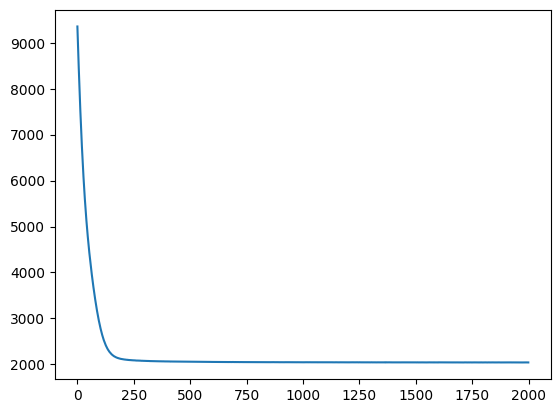

In [4]:
plt.plot(losses)

In [5]:
## get sample names and obs
Cite_GEX = sc.read_h5ad("/mnt/storage/anna/data/Cite_GEX_downsampled.h5ad")
Cite_ADT = sc.read_h5ad("/mnt/storage/anna/data/Cite_ADT_downsampled.h5ad")
sample_names = Cite_GEX.obs_names
gene_names = Cite_GEX.var_names
protein_names = Cite_ADT.var_names
gene_names = [s.replace('-1', '') for s in gene_names]
protein_names = [s.replace('-1', '') for s in protein_names]
shared_names = [name  for name in list(gene_names) if name in list(protein_names)]

In [6]:
# Find indices of shared gene/protein names to drop them
gene_idx = [gene_names.index(x) for x in shared_names]
prot_idx = [protein_names.index(x) for x in shared_names]

#gene_names_filtered = del gene_names[gene_idx]
#prot_names_filtered = del prot_names[prot_idx]

In [7]:
gene_names_filtered = [val for idx, val in enumerate(gene_names) if idx not in gene_idx]
prot_names_filtered = [val for idx, val in enumerate(protein_names) if idx not in prot_idx]

In [8]:
ad_factors = ad.AnnData(factors.detach().cpu().numpy(),obs = Cite_GEX.obs)
ad_W1 = ad.AnnData(W1.detach().cpu().numpy().T)
ad_W2 = ad.AnnData(W2.detach().cpu().numpy().T)
ad_Wshared = ad.AnnData(W_shared.detach().cpu().numpy().T)
ad_W1.var_names = prot_names_filtered
ad_W2.var_names = gene_names_filtered
ad_Wshared.var_names = shared_names


In [28]:
ad_W1.obs["factor"] = ["0","1","2","3","4","5","6","7","8","9"]
ad_W2.obs["factor"] = ["0","1","2","3","4","5","6","7","8","9"]
ad_Wshared.obs["factor"] = ["0","1","2","3","4","5","6","7","8","9"]

ad_W1.obs["factor"]=ad_W1.obs["factor"].astype('category')
ad_W2.obs["factor"]=ad_W2.obs["factor"].astype('category')
ad_Wshared.obs["factor"]=ad_Wshared.obs["factor"].astype('category')

In [10]:
## show umap view of mofa embedding
sc.pp.neighbors(ad_factors,)
sc.tl.umap(ad_factors, random_state=1)

In [11]:
cell_group = []

for cell in ad_factors.obs["cell_type"]: 
    if "CD8+" in cell: 
        cell_group.append("CD8+")
    elif "B1" in cell: 
        cell_group.append("B1")
    elif "CD4+" in cell: 
        cell_group.append("CD4+")
    elif "Plasma" in cell: 
        cell_group.append("Plasma cell")
    elif "NK" in cell:
        cell_group.append("NK")
    elif ("gdT TCRVD2+" in cell) or ("dnT" in cell) or ("cDC1" in cell) or ("T prog cycling" in cell):
        cell_group.append("Other")
    elif "Naive CD20+ B IGKC" in cell:
        cell_group.append("Naive CD20+ B IGKC")
    elif "ILC" in cell:
        cell_group.append("ILC")
    else: 
        cell_group.append(cell)

In [12]:
ad_factors.obs["cell_group"] = cell_group

In [13]:
celltype_counter = collections.Counter(ad_factors.obs["cell_group"])
celltype_counter

Counter({'B1': 143,
         'CD4+': 1399,
         'CD8+': 1064,
         'CD14+ Mono': 2169,
         'CD16+ Mono': 263,
         'Erythroblast': 403,
         'G/M prog': 188,
         'HSC': 170,
         'ILC': 78,
         'Lymph prog': 168,
         'MAIT': 75,
         'MK/E prog': 69,
         'NK': 759,
         'Naive CD20+ B IGKC': 596,
         'Normoblast': 143,
         'Plasma cell': 87,
         'Proerythroblast': 151,
         'Reticulocyte': 427,
         'Other': 27,
         'T reg': 60,
         'Transitional B': 157,
         'cDC2': 170,
         'gdT CD158b+': 67,
         'pDC': 175})

In [14]:
# Add factor activities to the obs
ad_factors.obs["factor_0"] = ad_factors.X[:,0]
ad_factors.obs["factor_1"] = ad_factors.X[:,1]
ad_factors.obs["factor_2"] = ad_factors.X[:,2]
ad_factors.obs["factor_3"] = ad_factors.X[:,3]
ad_factors.obs["factor_4"] = ad_factors.X[:,4]
ad_factors.obs["factor_5"] = ad_factors.X[:,5]
ad_factors.obs["factor_6"] = ad_factors.X[:,6]
ad_factors.obs["factor_7"] = ad_factors.X[:,7]
ad_factors.obs["factor_8"] = ad_factors.X[:,8]
ad_factors.obs["factor_9"] = ad_factors.X[:,9]

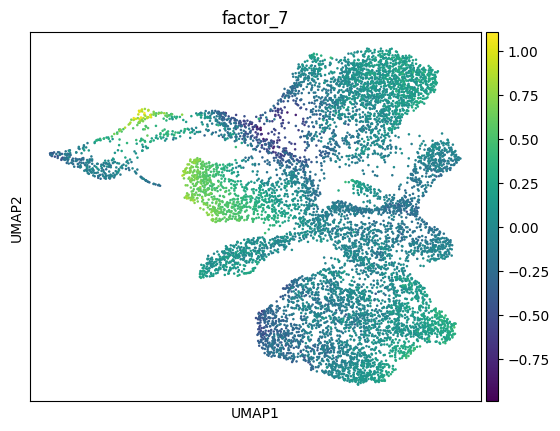

In [287]:

sc.pl.umap(ad_factors, color =["factor_7"], ncols=1, save="factor7_umap_factors.pdf")


/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


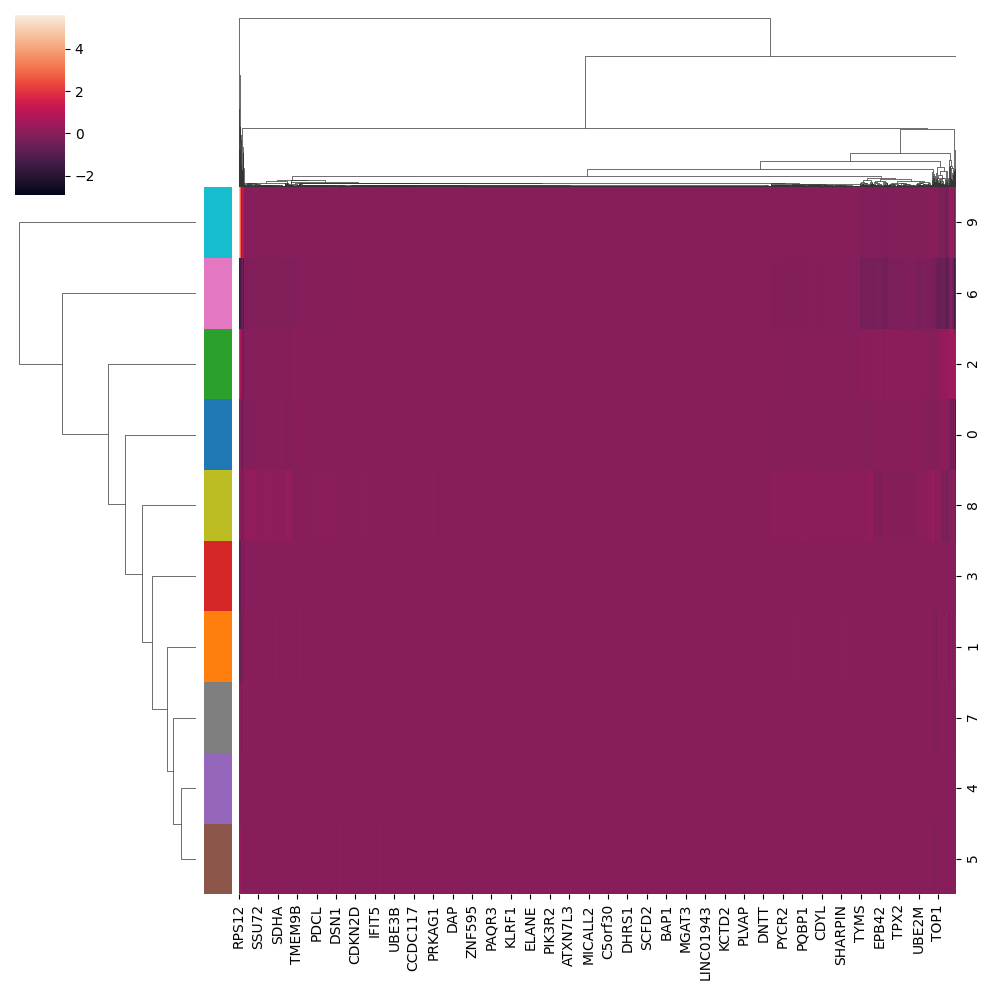

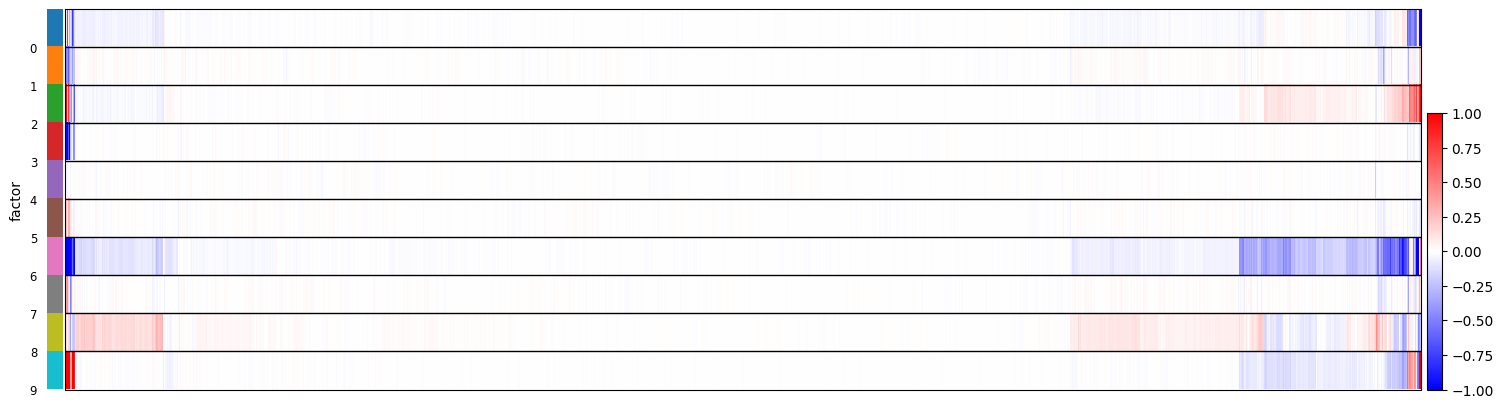

In [33]:
#order heatmap
sc.tl.dendrogram(ad_W2, use_rep="X", groupby="factor")
reordered_cols = sc.pl.clustermap(ad_W2, obs_keys="factor", show = False).dendrogram_col.reordered_ind
order = ad_W2.var_names[reordered_cols]
sc.pl.heatmap(ad_W2,var_names = order, groupby= "factor",  cmap = "bwr", swap_axes = False, figsize=(18,5), vcenter = 0,  show_gene_labels = False, save="W2_heatmap.pdf", vmax = 1, vmin = -1)
#sc.pl.clustermap(ad_W2,  cmap = "bwr", figsize=(18,5), row_cluster = False, center = 0, dendrogram_ratio = 0.001)

**Function to plot the weights of a given factor in both modalities:**

In [185]:
def plot_weights(W1, W2, W_shared, factor, top_features, save = None):
   # Fucntion that takes the weight matrices W1 and W2 and plots the 10 highest and lowest weight features for a given factor 
        W1_data = pd.DataFrame(W1.X, columns = W1.var_names)
        W2_data = pd.DataFrame(W2.X, columns = W2.var_names)
        W_shared = pd.DataFrame(W_shared.X, columns = shared_names)
        # Subset W1 and W2 to only feature the top 10 highest and lowest weights for the factor
        
        W1_data = W1_data.iloc[factor,:]
        W2_data = W2_data.iloc[factor,:]
        W_shared = W_shared.iloc[factor,:]
        # Sort the weights
        W1_sorted = W1_data.sort_values()
        W2_sorted = W2_data.sort_values()
        W_shared_sorted = W_shared.sort_values()
        
        # Get the x highest and lowest weights
        W1_top = np.concatenate((W1_sorted[:top_features], W1_sorted[-top_features:]))
        W2_top = np.concatenate((W2_sorted[:top_features], W2_sorted[-top_features:]))
        W_shared_top = np.concatenate((W_shared_sorted[:top_features], W_shared_sorted[-top_features:]))

        fig = plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.barh(list(W1_sorted.index[:top_features])+list(W1_sorted.index[-top_features:]) , W1_top)
        plt.title("Factor " + str(factor) + " ADT")
        plt.subplot(1, 3, 2)
        plt.barh(list(W2_sorted.index[:top_features])+list(W2_sorted.index[-top_features:]) , W2_top)
        plt.title("Factor " + str(factor) + " GEX")
        plt.subplot(1, 3, 3)
        plt.barh(list(W_shared_sorted.index[:top_features])+list(W_shared_sorted.index[-top_features:]) , W_shared_top)
        plt.title("Factor " + str(factor) + " shared")
        plt.subplots_adjust(wspace=0.5)
        fig.suptitle('Weights of the top and bottom 10 features for factor ' + str(factor) + ' in ADT, GEX and shared')
        
        if save is not None:
                fig.savefig(f"{save}/weights_factor_{str(factor)}.pdf", bbox_inches='tight')
        else:
                plt.show() 
        
        

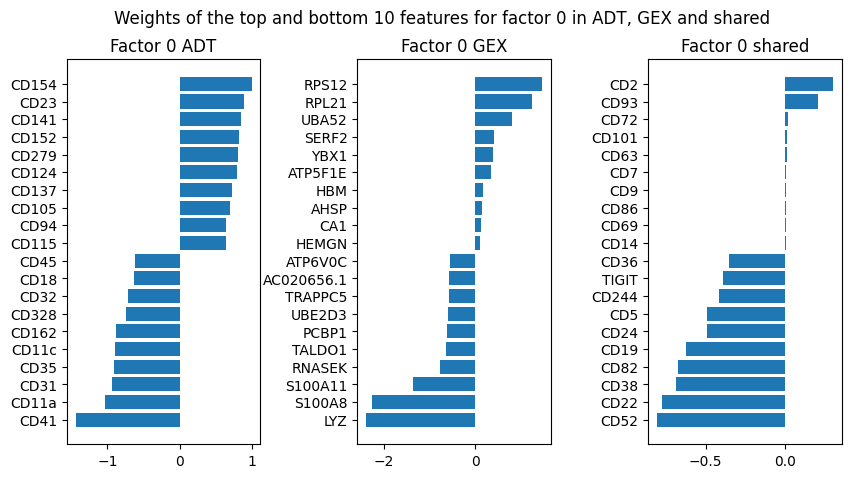

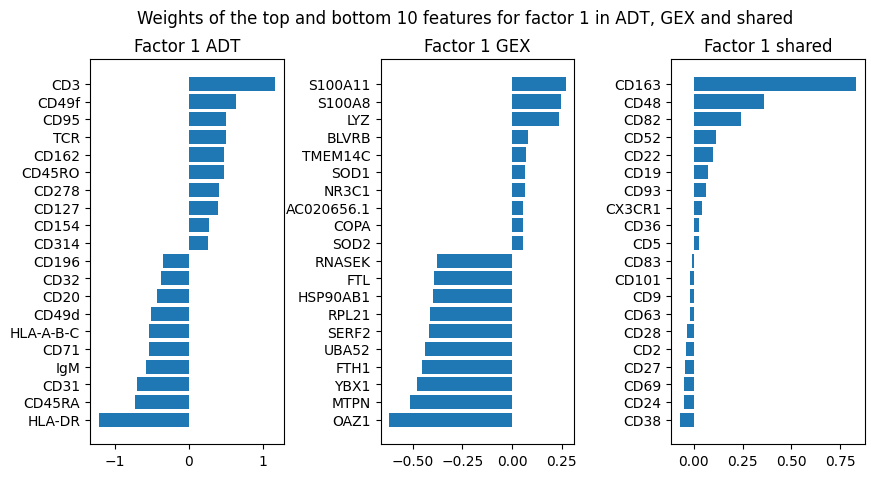

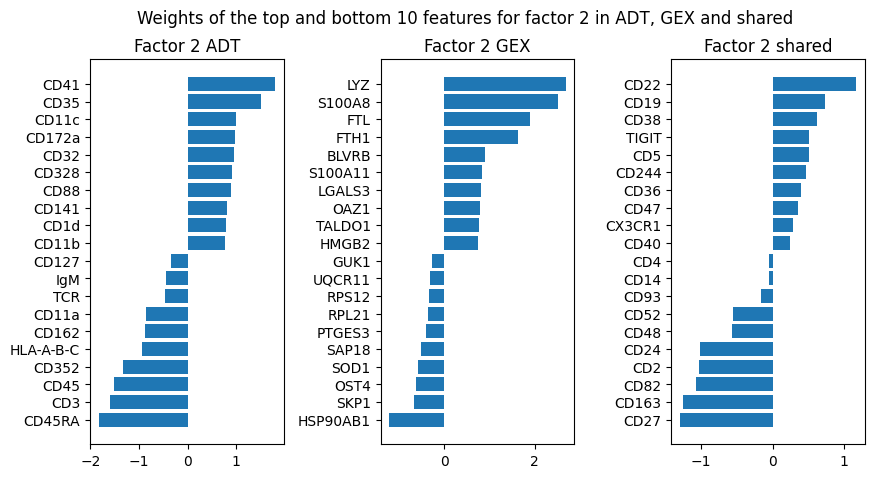

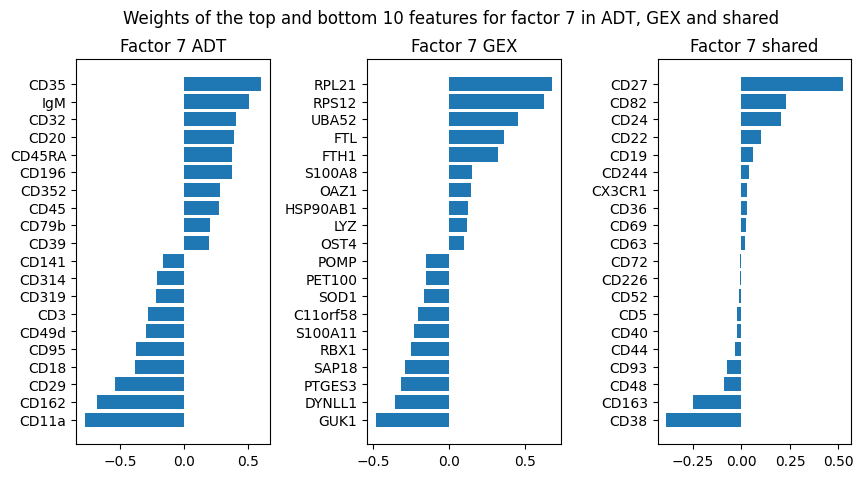

In [299]:

for factor in [0, 1, 2, 7]: 
    plot_weights(ad_W1, ad_W2, ad_Wshared, factor, 10, save = "/mnt/storage/paul/DeepLife/project/figures")

In [15]:
# GSEA analysis
W2_data = pd.DataFrame(ad_W2.X, columns = ad_W2.var_names)
#W2_data = pd.DataFrame(W2.X, columns = W2.var_names)
#W_shared = pd.DataFrame(W_shared.X, columns = shared_names)
# Subset W1 and W2 to only feature the top 10 highest and lowest weights for the factor

W2_data = W2_data.iloc[0,:]
#W2_data = W2_data.iloc[factor,:]
#W_shared = W_shared.iloc[factor,:]
# Sort the weights
W2_sorted = W2_data.sort_values(ascending = False)
#W2_sorted = W2_data.sort_values()
#W_shared_sorted = W_shared.sort_values()

W2_sorted = W2_sorted.reset_index()
print(W2_sorted)

        index         0
0       RPS12  1.468885
1       RPL21  1.253179
2       UBA52  0.799629
3       SERF2  0.421321
4        YBX1  0.385439
...       ...       ...
2691   TALDO1 -0.640696
2692   RNASEK -0.767955
2693  S100A11 -1.365408
2694   S100A8 -2.253404
2695      LYZ -2.386507

[2696 rows x 2 columns]


In [16]:
pre_res = gp.prerank(rnk=W2_sorted, # or rnk = rnk,
                     gene_sets='GO_Biological_Process_2023',
                     threads=2,
                     min_size=15,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

2024-06-14 07:54:44,680 [INFO] Parsing data files for GSEA.............................
2024-06-14 07:54:44,688 [INFO] Enrichr library gene sets already downloaded in: /home/paul2/.cache/gseapy, use local file


2024-06-14 07:54:44,807 [INFO] 5004 gene_sets have been filtered out when max_size=1000 and min_size=15
2024-06-14 07:54:44,809 [INFO] 0403 gene_sets used for further statistical testing.....
2024-06-14 07:54:44,810 [INFO] Start to run GSEA...Might take a while..................
2024-06-14 07:54:49,033 [INFO] Congratulations. GSEApy runs successfully................



In [243]:
pre_res.res2d.shape

(403, 10)

In [244]:

pre_res.res2d.loc[-1] = [0,0,0,0,0,0,0,0,0,0]  # adding a row
pre_res.res2d.index = pre_res.res2d.index + 1  # shifting index
pre_res.res2d = pre_res.res2d.sort_index()

In [249]:
pre_res.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,0,0,0,0,0,0,0,0,0,0
1,prerank,Erythrocyte Differentiation (GO:0030218),0.869921,1.89373,0.053691,0.500543,0.467,9/15,4.86%,AHSP;ALAS2;KLF1;TSPO2;SLC1A5;DMTN;MFHAS1;GATA1...
2,prerank,Inflammatory Response (GO:0006954),-0.954841,-1.868025,0.0,0.0,0.0,3/28,1.56%,LYZ;S100A8;PRDX5
3,prerank,Defense Response To Bacterium (GO:0042742),-0.974035,-1.855311,0.0,0.0,0.0,3/23,0.52%,LYZ;S100A8;HMGB2
4,prerank,Positive Regulation Of Cell Growth (GO:0030307),-0.936537,-1.771743,0.0,0.094486,0.181,3/19,0.89%,S100A8;SDCBP;MTPN
...,...,...,...,...,...,...,...,...,...,...
399,prerank,Defense Response To Virus (GO:0051607),-0.248252,-0.480469,0.986502,0.990391,1.0,8/34,31.23%,PQBP1;APOBEC3C;CHMP3;TANK;MORC3;NT5C3A;SERINC3...
400,prerank,Defense Response To Symbiont (GO:0140546),-0.237596,-0.461879,0.986471,0.99226,1.0,7/27,34.79%,PQBP1;APOBEC3C;TANK;NT5C3A;SERINC3;IRF2;ISG15
401,prerank,Calcium-Mediated Signaling (GO:0019722),-0.248083,-0.461678,0.984848,0.989668,1.0,1/15,8.68%,FIS1
402,prerank,Positive Regulation Of Kinase Activity (GO:003...,-0.242134,-0.447667,0.991841,0.989909,1.0,4/15,31.19%,RAD50;RAPGEF2;PTK2B;TAB2


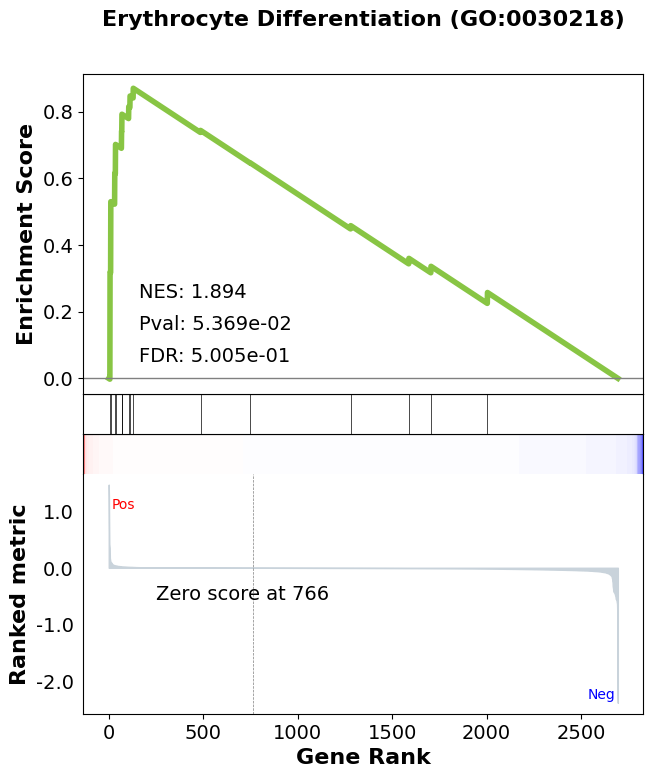

In [21]:
terms = pre_res.res2d.Term

axs = pre_res.plot(terms=terms[0],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(7,8)
                  ).savefig("/mnt/storage/paul/DeepLife/project/figures/GSEA_GO_Biological_Process_2023.pdf")

In [247]:
pre_res.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,0,0,0,0,0,0,0,0,0,0
1,prerank,Erythrocyte Differentiation (GO:0030218),0.869921,1.89373,0.053691,0.500543,0.467,9/15,4.86%,AHSP;ALAS2;KLF1;TSPO2;SLC1A5;DMTN;MFHAS1;GATA1...
2,prerank,Inflammatory Response (GO:0006954),-0.954841,-1.868025,0.0,0.0,0.0,3/28,1.56%,LYZ;S100A8;PRDX5
3,prerank,Defense Response To Bacterium (GO:0042742),-0.974035,-1.855311,0.0,0.0,0.0,3/23,0.52%,LYZ;S100A8;HMGB2
4,prerank,Positive Regulation Of Cell Growth (GO:0030307),-0.936537,-1.771743,0.0,0.094486,0.181,3/19,0.89%,S100A8;SDCBP;MTPN
...,...,...,...,...,...,...,...,...,...,...
399,prerank,Defense Response To Virus (GO:0051607),-0.248252,-0.480469,0.986502,0.990391,1.0,8/34,31.23%,PQBP1;APOBEC3C;CHMP3;TANK;MORC3;NT5C3A;SERINC3...
400,prerank,Defense Response To Symbiont (GO:0140546),-0.237596,-0.461879,0.986471,0.99226,1.0,7/27,34.79%,PQBP1;APOBEC3C;TANK;NT5C3A;SERINC3;IRF2;ISG15
401,prerank,Calcium-Mediated Signaling (GO:0019722),-0.248083,-0.461678,0.984848,0.989668,1.0,1/15,8.68%,FIS1
402,prerank,Positive Regulation Of Kinase Activity (GO:003...,-0.242134,-0.447667,0.991841,0.989909,1.0,4/15,31.19%,RAD50;RAPGEF2;PTK2B;TAB2


In [248]:
#from gseapy import dotplot
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(pre_res.res2d[1:,:],
             column="FDR q-val",
             title='GO_Biological_Process_2023',
             cmap=plt.cm.viridis,
             size=6, # adjust dot size
             figsize=(4,5), cutoff=0.3, show_ring=False)

InvalidIndexError: (slice(1, None, None), slice(None, None, None))